# Synthetic Data Exploration

In this file, I will be implementing different ecological spread models to generate synthetic geospatial population data for invasive species modeling. Per our conversation on 3/6/24, Professor Brantingham recommended that we implement the **Lotka-Volterra Model** and the **Tilman model** to understand competition between two species. I will be implementing these as a starting point.

## Lotka-Voltera Model

This model explores how competition influences the abundance of two competing species in a region where the specific competitive mechanism does not need to be known. This model originated in modeling predator-prey dynamics, which translates very well to our invasive species context where invasive species are the predators.

To implement this model, we will be using the following tutorial to get started: https://softinery.com/blog/lotka-volterra-model-and-simulation/, that breaks down the implemntation into x parts:
- imports
- defining the optimization equations
- initializing the environment
- solving the environment over time
- plotting the results

Note that this tutorial works on a specific region and the number of predator and prey species at a given timestep. For our purposes, we want a geospatial map of related points where these numbers are calculated to create a heat-map of predator locations. I found this paper that explicitly discusses L-V heatmaps in section 4.4.3: https://ppgfis.ufba.br/sites/ppgfis.ufba.br/files/rafael_menezes_msc_dissertationupdated.pdf. The general theoretic idea is to use a specified aggregation function to gather the numbers of predators at a certain timestep for a given unit area of a region and to shade that region accordingly. As the original repo from the paper is dead, I found some potential github leads:
- https://github.com/r-menezes/SpatialPreyPred/tree/main: seems to generate vector fields of species
- https://github.com/SteevenJanny/DeepKKL/blob/master/data_generation/datagen_LotkaVolterra.py: seems to generate LV data, not sure about expansion to heatmaps

In [7]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm

# Constants: Simulation Parameters
ALPHA = 2 / 3
BETA = 4 / 3
GAMMA = 1
DELTA = 1

# CATHERINE: Okay, I honestly don't really know what's going on here, but I feel like what we are TRYING to do is to create a version of Lotka-Volterra which is "spatially aware". However, I think it's slightly more complicated than the code below. For starters, I don't think we can simply cut up our grid into small pieces and run a small L-V model in each grid because this ignores the fact that animals can move between grids. I just don't think it's that simple to go from spatially unaware L-V -> spatially aware L-V. However, Prof. Brantingham's paper does propose a spatially aware L-V, and it requires us to solve a system of PDEs, which is kind of difficult. You can go to my notebook in catherine_lv to see more. tldr: not quite sure what this code is doing, but I don't think it completes the goal of create spatially aware L-V. But I might also be misunderstanding it, so I think we should have a conversation on Monday where Lauren explains. But I really think we need to be careful that our code is actually doing something reasonable ... 

def generate_heatmap(grid_size=100, num_traj=200, len_traj=25, save_loc='../Data/val.npy'):
    dataset = np.zeros((num_traj, grid_size, grid_size))

    for k in tqdm(range(num_traj)):
        # Initialize a grid with random predator numbers
        grid = np.random.random((grid_size, grid_size))

        # Run Lotka-Volterra model to simulate predator numbers changing over time
        t_span = [0, len_traj]
        t_grid = np.linspace(t_span[0], t_span[1], len_traj)
        dt = t_grid[1] - t_grid[0]  # Time step

        for t_idx, t in enumerate(t_grid):
            predator_population = np.zeros((grid_size, grid_size))

            # Iterate over grid cells
            for i in range(grid_size):
                for j in range(grid_size):
                    # CATHERINE: confused, because above it says that we initialize a grid with random predator numbers, but now we're talking about prey? 
                    prey = grid[i, j]
                    prey_neighbors = grid[(i+1)%grid_size, (j+1)%grid_size]  # Using toroidal boundary conditions
                    # CATHERINE: Where did this come from? Because this is not what the Lotka-Volterra model says. In fact, the Lotka Volterra model requires us to solve a system of differential equations (e.g. solve_ivp or odeint), but I don't see that anywhere here. I've tried to understand what's being done here / the inspiration behind it by reading all the links attached, but I don't see anything. 
                    predator_population[i, j] = prey * (ALPHA - BETA * prey_neighbors)

            # Update the grid with the new predator population
            grid += predator_population * dt
            grid = np.clip(grid, 0, 1)  # Ensure predator numbers stay within [0, 1]

        # Assign the predator population to the grid
        dataset[k] = grid

    np.save(save_loc, dataset)
    return dataset

# Example usage
dataset = generate_heatmap()


100%|██████████| 200/200 [00:47<00:00,  4.24it/s]


In [6]:
# generate interactive plot

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider

def plot_predator_locations(grid, timestep):
    plt.figure(figsize=(8, 8))
    plt.imshow(grid[timestep], cmap='hot', origin='lower')
    plt.colorbar(label='Predator Population')
    plt.title(f'Predator Locations at Timestep {timestep}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Function to plot predator locations at a specified timestep
def plot_predator_locations_at_timestep(file_loc, timestep):
    dataset = np.load(file_loc)
    plot_predator_locations(dataset, timestep)

# Define the maximum timestep based on the dataset
max_timestep = np.load('../Data/val.npy').shape[0] - 1

# Print a message before running the interactive plot
print("Starting interactive plot...")

# Create an interactive slider
interact(plot_predator_locations_at_timestep, file_loc='../Data/val.npy', timestep=IntSlider(min=0, max=max_timestep, step=1, value=0))

# Print a message after the interactive plot is finished
print("Interactive plot finished.")

Starting interactive plot...


interactive(children=(Text(value='../Data/val.npy', description='file_loc'), IntSlider(value=0, description='t…

Interactive plot finished.


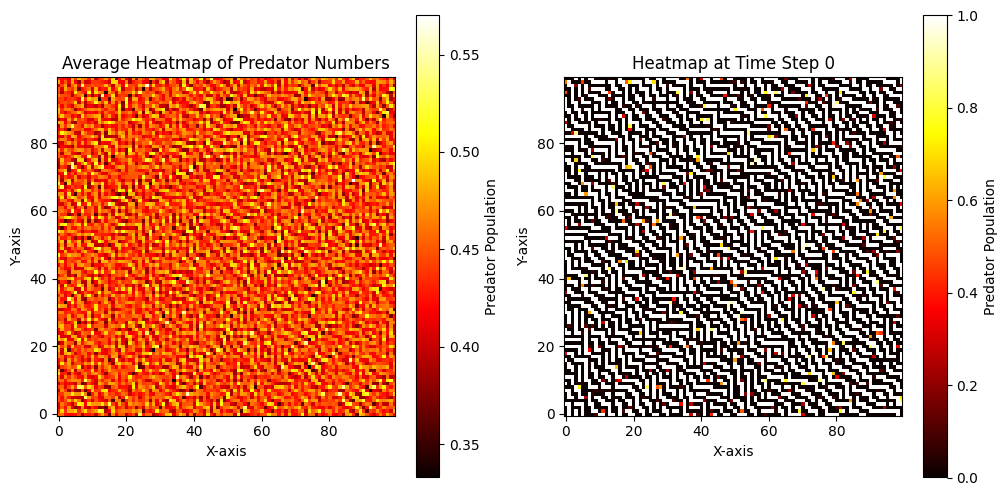

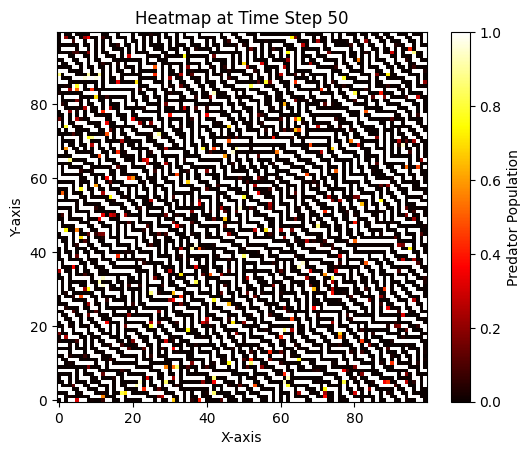

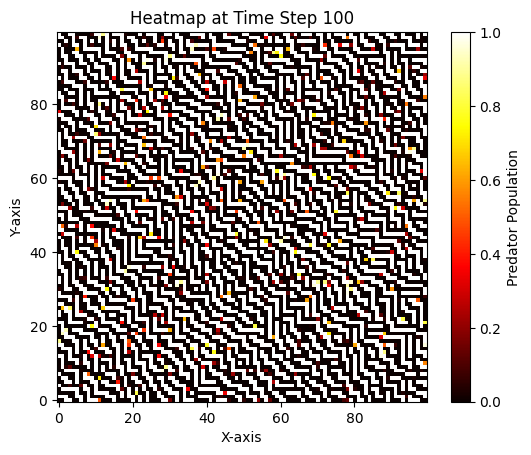

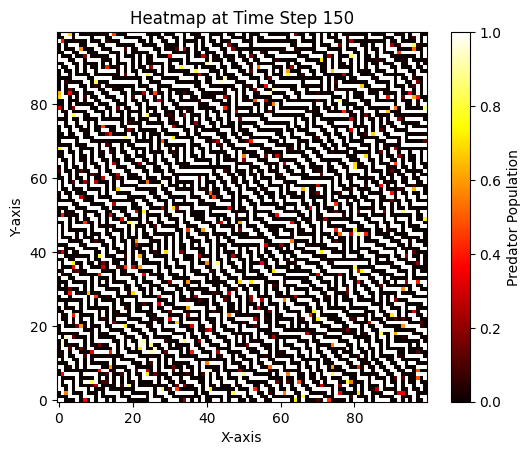

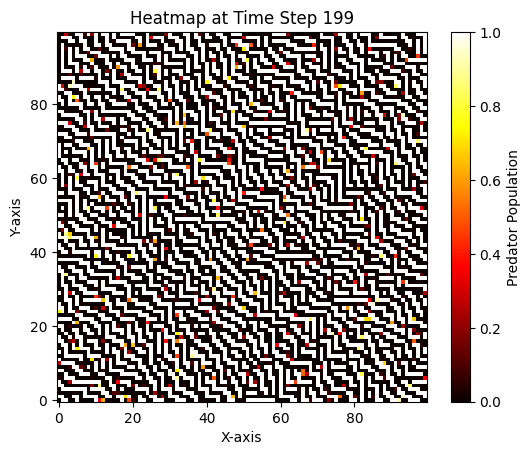

In [ ]:
# some static plots to look at

import numpy as np
import matplotlib.pyplot as plt

# Load the generated heatmap data
dataset = np.load('../Data/val.npy')

# Calculate average heatmap
average_heatmap = np.mean(dataset, axis=0)

# Plot the average heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(average_heatmap, cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Predator Population')
plt.title('Average Heatmap of Predator Numbers')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Select representative timesteps
representative_time_steps = [0, len(dataset)//4, len(dataset)//2, 3*len(dataset)//4, len(dataset)-1]

# Plot representative timesteps and their heatmaps
plt.subplot(1, 2, 2)
for timestep in representative_time_steps:
    heatmap_data = dataset[timestep]
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar(label='Predator Population')
    plt.title(f'Heatmap at Time Step {timestep}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


## Scratch Work

In [3]:
# data generation. Based on work from https://github.com/SteevenJanny/DeepKKL/blob/master/data_generation/datagen_LotkaVolterra.py

# imports
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm

#Constants: Simulation Parameters
ALPHA = 2 / 3
BETA = 4 / 3
GAMMA = 1
DELTA = 1

# lotka-volterra model dynamics. Defines the partials in terms of the simulation constants
# CATHERINE: vector y holds [prey(t), predator(t)] and vector out returns the equations of L-V
def dynamics(t, y):
    """Lotka Volterra model"""
    out = np.zeros_like(y)
    out[0] = y[0] * (ALPHA - BETA * y[1])
    out[1] = y[1] * (DELTA * y[0] - GAMMA)
    return out


'''generate(): creates np file simulating multiple trajectories of Lotka Volterra's system. The args are:
    num_traj: number of trajectories to simulate. default 200
    len_traj: length of a trajectory (in seconds). default 25
    pts_per_sec: number of points per second. default 40
    save_loc: where to save created files
'''
def generate(num_traj=200,len_traj=25, pts_per_sec=100,save_loc='../Data/val.npy',prey_range=(1, 5), predator_range=(1, 3)):
    dataset = np.zeros((num_traj, 2, len_traj * pts_per_sec))  # That will store each simulation
    t_span = [0, len_traj]
    t_eval = np.linspace(0, len_traj, len_traj * pts_per_sec)  # Time vector

    # Change this line to configure how much you downsample the data, and the final time range
    downsample_rate = int(len(t_eval) / (len_traj * pts_per_sec))
    idx = np.arange(0, len(t_eval), downsample_rate)

    for k in tqdm(range(num_traj)):
        # Generate random initial values for prey and predator populations within the specified ranges
        
        # CATHERINE: unsure why we're creating a vector y0, overwriting the second value, and then recreating it?
        y0 = np.random.uniform(prey_range[0], prey_range[1], size=2)
        y0[1] = np.random.uniform(predator_range[0], predator_range[1])

        y0 = np.random.random(2) * 2
        sol = solve_ivp(dynamics, y0=y0, t_span=t_span, t_eval=t_eval)
        dataset[k] = sol.y[:, idx]

    np.save(save_loc, dataset)

generate()

100%|██████████| 200/200 [00:01<00:00, 121.70it/s]


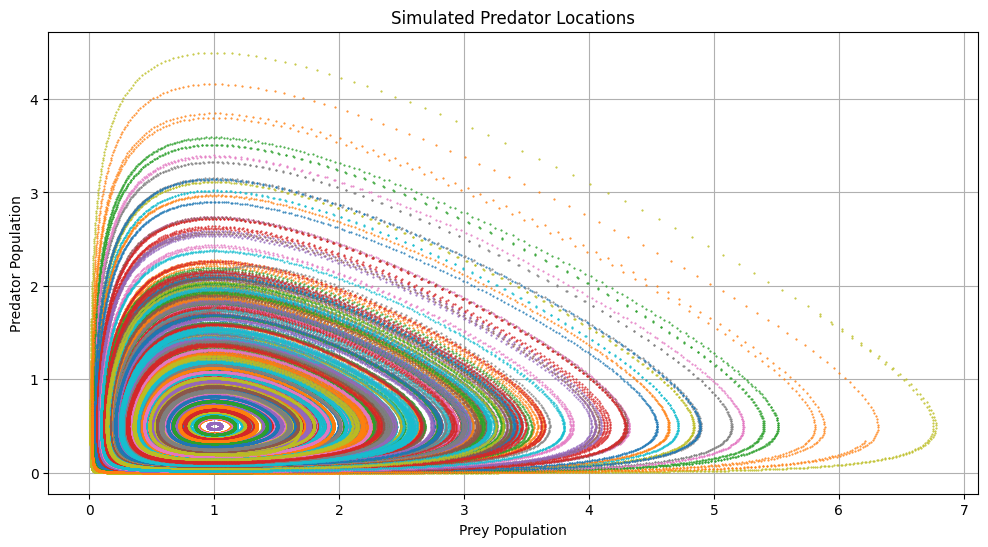

In [4]:
# intuition check on simulated data
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file containing the simulation data
data = np.load('../Data/val.npy')

# Extract prey and predator population data
prey_data = data[:, 0, :]
predator_data = data[:, 1, :]

# Plot the predator locations for each trajectory
# CATHERINE: not sure this is saying anything about "locations" - I think this is just a map that shows how prey/predator population vary with each other 
plt.figure(figsize=(12, 6))
plt.title('Simulated Predator Locations')

# Plot each trajectory separately
for traj_index in range(len(prey_data)):
    plt.plot(prey_data[traj_index], predator_data[traj_index], '.', markersize=1)

plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.grid(True)
plt.show()

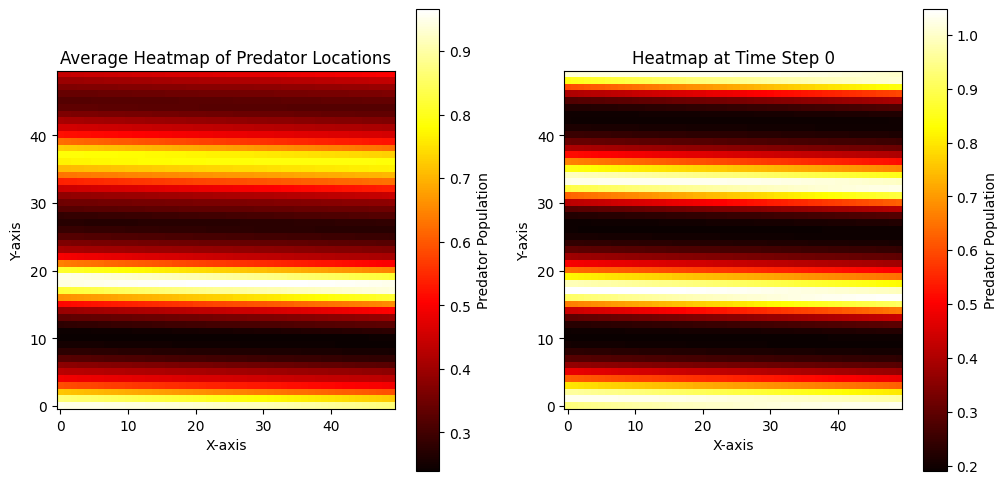

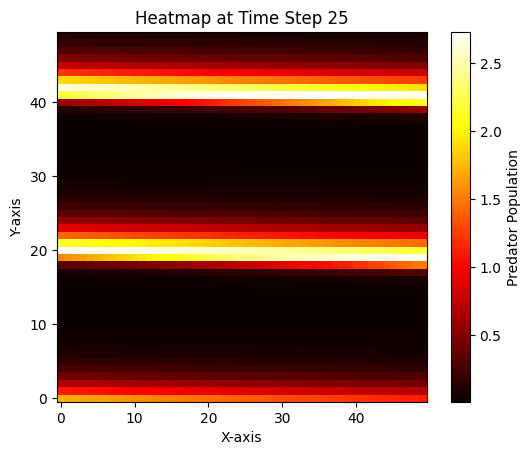

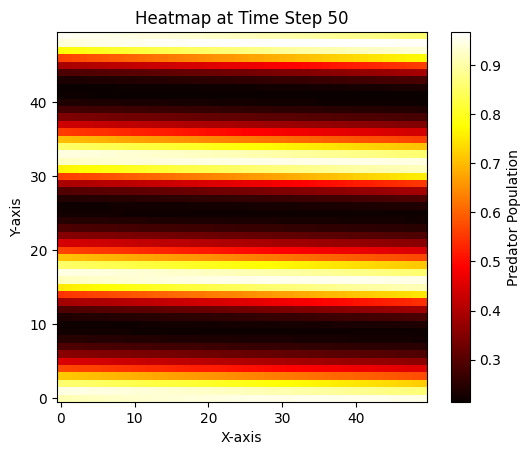

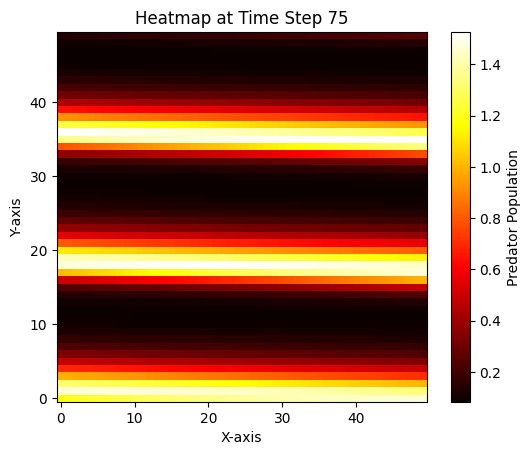

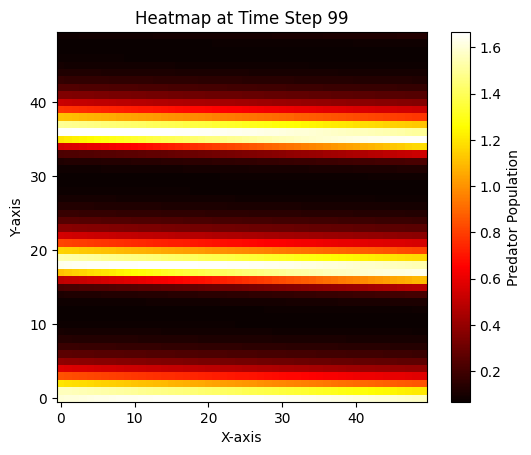

In [ ]:
# generation of data heatmaps
# CATHERINE: Once again, I think this is kind of misleading because the predator_data and prey_data used in this cell were generated by classic Lotka-Volterra which says nothing about "location" so I'm not actually sure what the X-axis and Y-axis mean in this context. 
#imports
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file containing the simulation data
data = np.load('../Data/val.npy')

# Extract predator population data (second variable in the array)
predator_data = data[:, 1, :]

# Calculate average predator population at each time step across all trajectories
average_predator_population = np.mean(predator_data, axis=0)

# Reshape the data into a 2D grid representing predator population over time
grid_size = int(np.sqrt(average_predator_population.shape[0]))
average_heatmap_data = average_predator_population.reshape((grid_size, grid_size))

# Plot the average heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(average_heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Predator Population')
plt.title('Average Heatmap of Predator Locations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Select representative time steps
representative_time_steps = [0, 25, 50, 75, 99]  # Adjust as needed

# Plot representative timestep heatmaps
plt.subplot(1, 2, 2)
for timestep in representative_time_steps:
    heatmap_data = predator_data[timestep].reshape((grid_size, grid_size))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar(label='Predator Population')
    plt.title(f'Heatmap at Time Step {timestep}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()